In [1]:
import os

if os.path.basename(os.getcwd()) != "Amsterdam-House-Price-Prediction": os.chdir("..")

# 🏡 Comparing Models for Amsterdam House Price Prediction

This notebook:
- Loads the **cleaned dataset**
- Trains several regression models
- Compares them using metrics
- Saves the trained models


🔹 Imports and configuration

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from src.preprocessing import load_cleaned_data
from src.train import scale_features, train_test_split_data
from src.evaluate import evaluate_model
from src.utils import save_model_named

sns.set(style="whitegrid")


🔹 Loading the cleaned data

In [3]:
df = load_cleaned_data(path="data/cleaned.csv")
df.head(2)


,price,area,rooms,price_per_sqm,area_per_room,lat_bin,lon_bin,distance_to_center_km,zip_prefix
0,685000.0,64.0,3.0,10703.125000,21.333333,52.36,4.91,1.297179,1091
1,475000.0,60.0,3.0,7916.666667,20.000000,52.35,4.85,4.221765,1059


🔹 Splitting into features and target

In [4]:
FEATURES = ["area", "rooms", "price_per_sqm", "area_per_room", "lat_bin", "lon_bin", "distance_to_center_km", "zip_prefix"]
TARGET = "price"

X = df[FEATURES]
y = df[TARGET]


🔹 Scaling and train/test split

In [5]:
X_scaled = scale_features(X.copy(), FEATURES)
X_train, X_test, y_train, y_test = train_test_split_data(X_scaled, y)


🔹 Defining the models

In [6]:
models = {
    "LinearRegression": LinearRegression(),
    "Ridge(alpha=1.0)": Ridge(alpha=1.0),
    "DecisionTree(depth=5)": DecisionTreeRegressor(max_depth=5),
    "RandomForest(n=50)": RandomForestRegressor(n_estimators=50, random_state=42)
}


🔹 Training, prediction, evaluation, and saving

In [7]:
results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    metrics = evaluate_model(y_test, y_pred)
    metrics["Model"] = name
    results.append(metrics)

    safe_name = name.lower().replace("(", "_").replace(")", "").replace("=", "_").replace(" ", "").replace(",", "")
    save_model_named(model, safe_name)


✅ Model saved: models\linearregression.joblib
✅ Model saved: models\ridge_alpha_1.0.joblib
✅ Model saved: models\decisiontree_depth_5.joblib
✅ Model saved: models\randomforest_n_50.joblib


🔹 Displaying the results

In [8]:
df_results = pd.DataFrame(results).set_index("Model")
df_results.style.background_gradient(cmap="Blues").format("{:.2f}")


,MAE,MSE,RMSE,R2
Model,,,,
LinearRegression,59425.23,14154977094.49,118974.69,0.89
Ridge(alpha=1.0),59312.28,14078205703.07,118651.61,0.89
DecisionTree(depth=5),70922.66,12560638070.66,112074.25,0.90
RandomForest(n=50),24285.04,4954542921.95,70388.51,0.96


🔹 Visualisation: actual vs predicted and feature importance

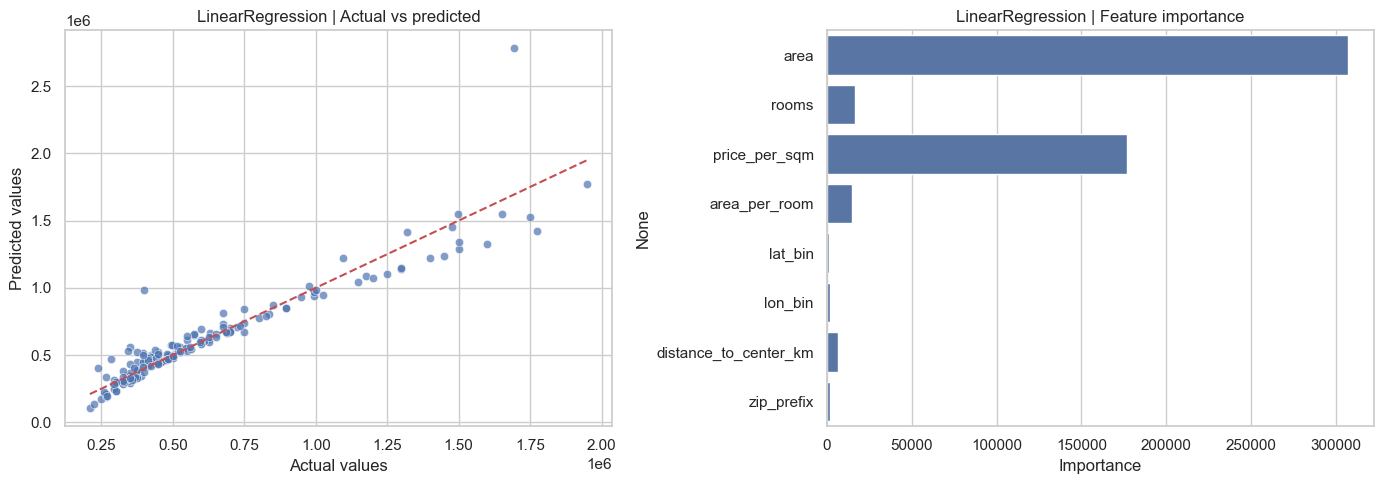

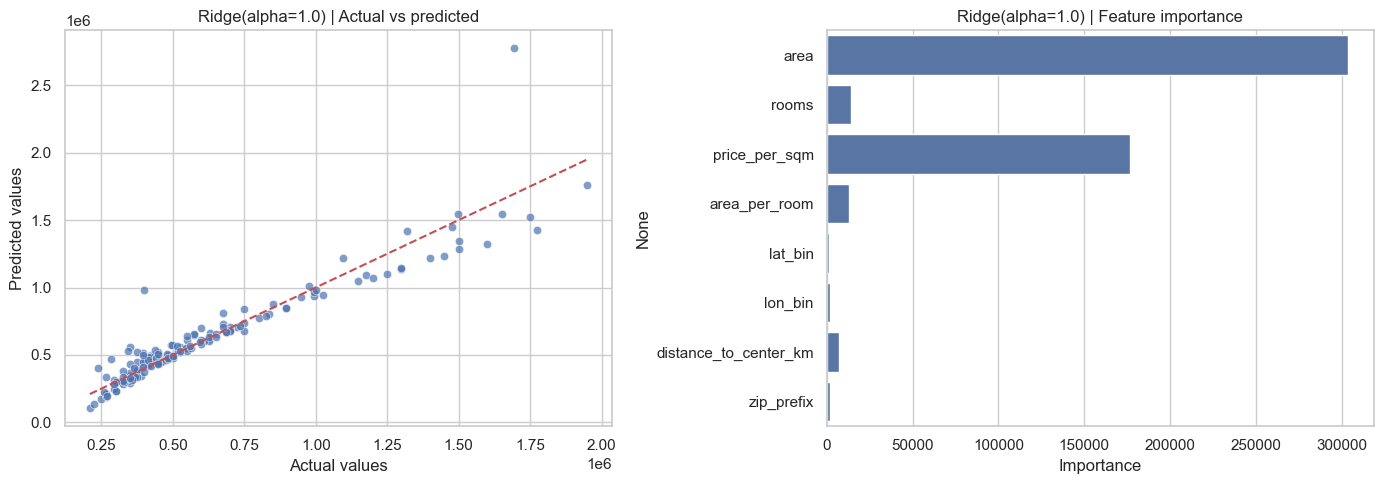

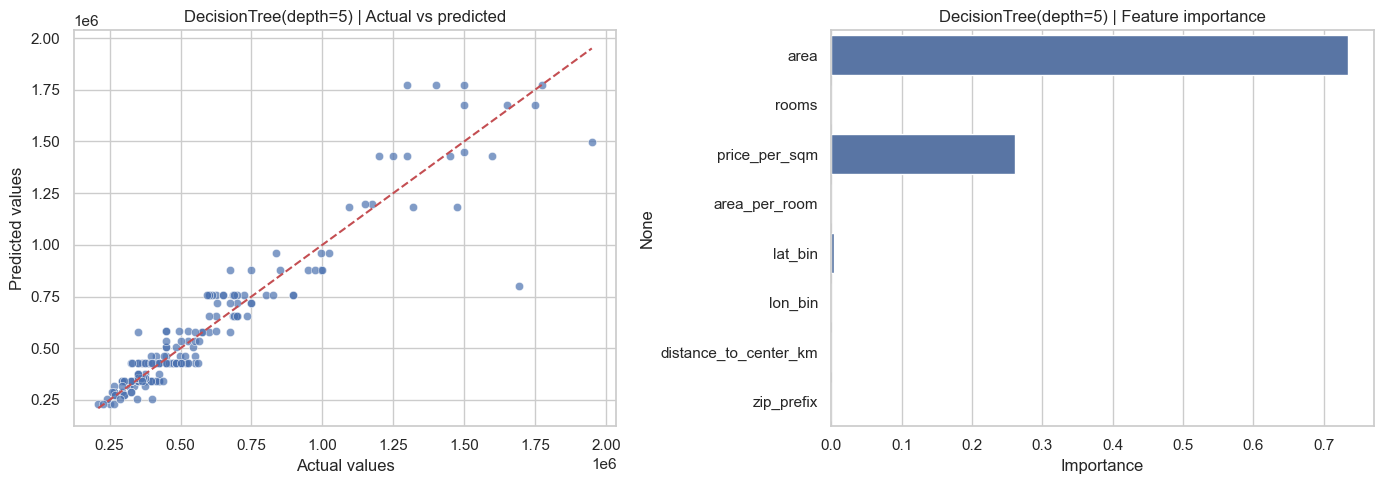

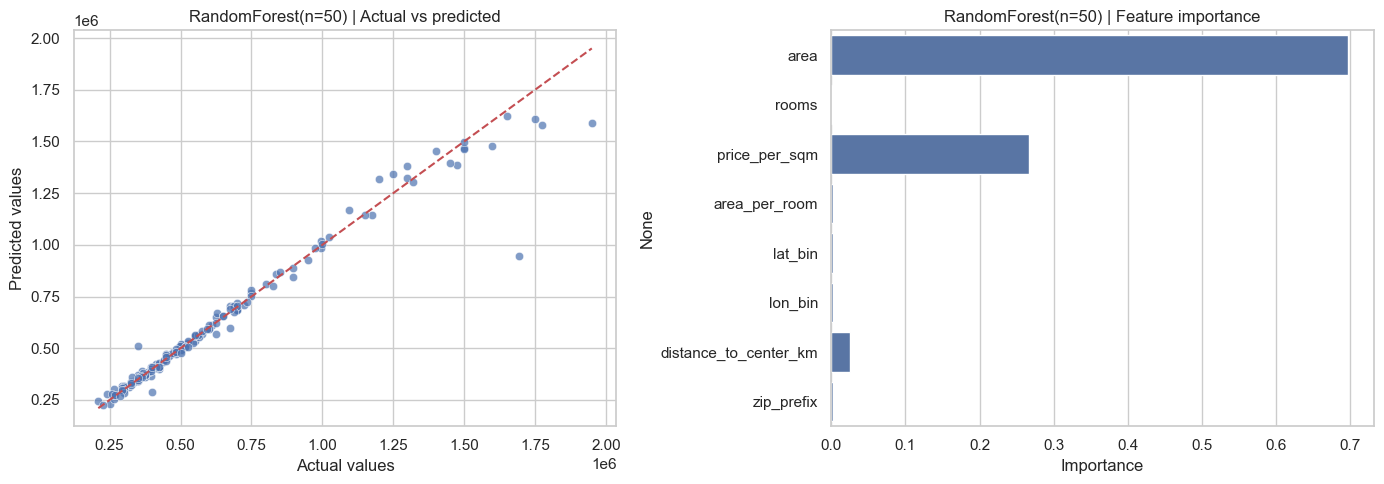

In [9]:
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # 🧮 Calculating feature importances
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
    elif hasattr(model, 'coef_'):
        importances = np.abs(model.coef_)
    else:
        importances = None

    # 📊 Two side-by-side plots
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Plot 1: Actual vs predicted values
    sns.scatterplot(ax=axes[0], x=y_test, y=y_pred, alpha=0.7)
    axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    axes[0].set_title(f"{name} | Actual vs predicted")
    axes[0].set_xlabel("Actual values")
    axes[0].set_ylabel("Predicted values")

    # Plot 2: Feature importance
    if importances is not None:
        sns.barplot(ax=axes[1], x=importances, y=X_train.columns, orient='h')
        axes[1].set_title(f"{name} | Feature importance")
        axes[1].set_xlabel("Importance")
    else:
        axes[1].set_visible(False)

    plt.tight_layout()
    plt.show()
